#6.8300 Final Project
## Catherine Mei and Linette Kunin

In [ ]:
# store as npy file
# plot in matplotlib
# is 2D array
# convert to pytorch tensor

# matplotlib as heatmap to try to visualize
# spectrogram will be our label
# spectrogram have to be scaled from 1 to -1
# make sure to normalize the data

# Enough for project

### Imports

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import os
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import imageio
import matplotlib.pyplot as plt
import time
import copy
from tqdm import tqdm
import torch.optim as optim

# import pickle
# from math import pi
# from torch.autograd import Variable
#
# import cv2


# import time
# from tqdm.notebook import tqdm
# import copy
# import pandas as pd
# import PIL
# from torch.utils.data import DataLoader
# import random

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")
    print("You may want to try to use the GPU in Google Colab by clicking in:")
    print("Runtime > Change Runtime type > Hardware accelerator > GPU.")

Using the GPU!


### Import Data

In [ ]:
use_gdrive = True

In [ ]:
if use_gdrive:
  from google.colab import drive
  drive.mount('/content/drive')

  data_dir = "/content/drive/MyDrive/6.8300FinalProject"
else:
  data_dir = "./data"

downloads_dir = data_dir + '/downloads'
datasets_dir = data_dir + '/vis-data-256'
processed_data_dir = data_dir + '/vis-data-processed'
models_dir = data_dir + '/models'
pretrained_models = data_dir + '/pretrained_models'
q2c_data_dir = data_dir + '/q2c_data'

Mounted at /content/drive


In [ ]:
# vis_low_res = datasets_dir + '/vis-data-256.zip'
# vis_sound_features = datasets_dir + '/vis-sfs.zip'

### Create Class for Dataset

In [ ]:
class VisData(Dataset):
  def __init__(self, split = 'train', mode='image'):
    self.image_transforms = transforms.Compose([
          transforms.ToPILImage(),
          transforms.RandomHorizontalFlip(0.5),
          transforms.RandomVerticalFlip(0.5),
          transforms.ToTensor(),
        ])

    self.imageToTensor = transforms.Compose([transforms.ToPILImage(), transforms.Grayscale(1), transforms.ToTensor()])

    self.split = split
    self.mode = mode

    self.inputs, self.labels = self.get_dataset_input_label()
    self.n = len(self.labels)

  def __getitem__(self, index):
    return self.inputs[index], self.labels[index]

  def __len__(self):
    return self.n

  def get_dataset_input_label(self):
    data_split = []

    input = []
    label = []

    # get videos in dataset depending on train or test split
    data_ids_path = ""
    if self.split in {'train', 'val'}:
      data_ids_path = processed_data_dir + "/train.txt"
    elif self.split == "test":
      data_ids_path = processed_data_dir + "/test.txt"

    with open(data_ids_path, 'r') as f:
        all_ids = f.read()
        all_ids = all_ids.split("\n")
        data_split = [id for id in all_ids if len(id)] # all of the video ids that are part of this dataset split

    ignore_files = {"2015-02-21-17-48-19", "2015-03-28-20-13-18"}
    file_count = 0
    # for each file id, get all the hits in that file
    for file_id in data_split:
      file_count+=1
      if file_id in ignore_files:
        continue
      video_id_path = processed_data_dir + "/" + file_id
      filenames = os.listdir(video_id_path)

      num_hits = len([i for i in filter(lambda x: x.endswith(".png"), filenames)])

      keep_hit = 0
      for i in range(num_hits):
        if i % 20 != keep_hit:
          continue
        try:
          input_in, spectro_label = self.get_stacked_image_spec(file_id, i)
          input.append(input_in)
          label.append(spectro_label)
        except:
          print("skipped: ", file_id, i)
          continue


      if file_count %50 ==0:
        print("loaded: ", file_count)

    return input, label

  def get_stacked_image_spec(self, file_id, i):
    img = self.load_image_with_id(file_id, i)
    spec = torch.tensor(self.get_spectrogram_for_hit(file_id, i))
    return [img, spec]

  def load_image_with_id(self, file_id, index, apply_transforms = True):
    file_path = processed_data_dir + "/" + file_id + "/" + file_id + "_image_" + str(index) + ".png"
    img = imageio.imread(file_path, pilmode='RGB')
    if apply_transforms:
      img = self.image_transforms(img)
    return img

  def get_material_label(self, file_id, index):
    file_path = processed_data_dir + "/" + file_id + "/" + file_id + "_labels_" + str(index) + ".txt"
    with open(file_path, 'r') as f:
      input = f.read()
      lines = input.split("\n")
      label = int(lines[0])
    return label

  def get_spectrogram_for_hit(self, file_id, index):
    file_path = processed_data_dir + "/" + file_id + "/" + file_id + "_spectrogram_" + str(index) + ".npy"
    spectrogram = np.load(file_path)
    spectrogram = spectrogram.flatten()
    #spectrogram = np.transpose(np.repeat(spectrogram[:, :, np.newaxis], 3, axis=2), (2,0,1))
    return spectrogram


In [ ]:
#data_stats_train = VisData(split = 'train', mode = 'sound')

In [ ]:
# image, label = data_stats_train[0]
# plt.imshow(np.transpose(image, (1,2,0)))

RNN that outputs the frequencies at each timepoint
look for pretrained model that outputs sounds?
computer vision models not good for this because doesn't capture dependencies well
Use generative models instead
adversairial audio synthesis (Donahue)
conditional model -
audio conditional generative models

coordconv

go from vector to spectrogram possibly with either __ * f *times or convolutional decoder and transpose convlution

spectrogram size = 1025 by 44

### Model Initialization

In [ ]:
def initialize_model(model_name, num_classes, resume_from = None, use_pretrained = False, mode = None):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    # The model (nn.Module) to return
    model_ft = None
    # The input image is expected to be (input_size, input_size)
    input_size = 0

    # By default, all parameters will be trained (useful when you're starting from scratch)
    # Within this function you can set .requires_grad = False for various parameters, if you
    # don't want to learn them

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "resnet50":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    else:
        raise Exception("Invalid model name!")

    if resume_from is not None:
        print("Loading weights from %s" % resume_from)
        model_ft.load_state_dict(torch.load(resume_from))

    return model_ft, input_size

## Dataloader

In [ ]:
def get_image_transforms():
    # How to transform the image when you are loading them.
    # you'll likely want to mess with the transforms on the training set.

    # We convert the image to a [C,H,W] tensor, then normalize it to values with a given mean/stdev. These normalization constants
    # are derived from the mean/stdev of the ImageNet training set which was used to pretrain our models.

    transform = transforms.Compose([
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    return transform

def get_dataloaders(input_size, batch_size, shuffle = True, transform=get_image_transforms()):
    data_transforms = {
        'train': VisData(split = "train"),
        'val': VisData(split = "val"),
        'test': VisData(split = "test")
    }
    # Create training, validation and test dataloaders
    # Never shuffle the test set
    dataloaders_dict = {x: DataLoader(data_transforms[x], batch_size=batch_size, shuffle=False if x != 'train' else shuffle, num_workers=4) for x in data_transforms.keys()}
    return dataloaders_dict

## Train Model

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, save_dir = None, save_all_epochs=False, num_epochs=25, eval_mode='multiclass'):
    '''
    model: The NN to train
    dataloaders: A dictionary containing at least the keys
                 'train','val' that maps to Pytorch data loaders for the dataset
    criterion: The Loss function
    optimizer: The algorithm to update weights
               (Variations on gradient descent)
    num_epochs: How many epochs to train for
    save_dir: Where to save the best model weights that are found,
              as they are found. Will save to save_dir/weights_best.pt
              Using None will not write anything to disk
    save_all_epochs: Whether to save weights for ALL epochs, not just the best
                     validation error epoch. Will save to save_dir/weights_e{#}.pt
    '''
    os.makedirs(save_dir, exist_ok=True)
    print(f'save dir is {save_dir}')
    since = time.time()

    val_acc_history = []
    train_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            # TQDM has nice progress bars
            for inputs, labels in tqdm(dataloaders[phase]):

                if eval_mode == 'singleclass':
                  labels = labels.type(torch.FloatTensor)

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    outputs = outputs.to(device)
                    loss = criterion(outputs, labels)

                    # torch.max outputs the maximum value, and its index
                    # Since the input is batched, we take the max along axis 1
                    # (the meaningful outputs)
                    if eval_mode == 'multiclass':
                      preds = torch.mean(outputs, 0)
                    elif eval_mode == 'multilabel':
                      preds = torch.sigmoid(outputs > 0.5).long()
                    elif eval_mode == 'singleclass':
                      preds = torch.sigmoid(outputs > 0.5).long()

                    # backprop + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)


            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'train':
                train_acc_history.append(epoch_acc)
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            if save_all_epochs:
                torch.save(model.state_dict(), os.path.join(save_dir, f'weights_{epoch}.pt'))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # save and load best model weights
    torch.save(best_model_wts, os.path.join(save_dir, 'weights_best_val_acc.pt'))
    torch.save(model.state_dict(), os.path.join(save_dir, 'weights_last.pt'.format(epoch)))
    model.load_state_dict(best_model_wts)
    print('saved weights?')

    with open(os.path.join(save_dir, 'train_history.txt'), 'w') as f:
      for i in range(num_epochs):
        f.write(str(train_acc_history[i])+'\n')

    with open(os.path.join(save_dir, 'val_history.txt'), 'w') as f:
      for i in range(num_epochs):
        f.write(str(val_acc_history[i])+'\n')
    print('saved progress?')

    return model, val_acc_history, train_acc_history

In [ ]:
# def train_model(model, dataloaders, criterion, optimizer, save_dir = None, save_all_epochs=False, num_epochs=25, eval_mode = "multiclass", mode = None):
#     '''
#     model: The NN to train
#     dataloaders: A dictionary containing at least the keys
#                  'train','val' that maps to Pytorch data loaders for the dataset
#     criterion: The Loss function
#     optimizer: The algorithm to update weights
#                (Variations on gradient descent)
#     num_epochs: How many epochs to train for
#     save_dir: Where to save the best model weights that are found,
#               as they are found. Will save to save_dir/weights_best.pt
#               Using None will not write anything to disk
#     save_all_epochs: Whether to save weights for ALL epochs, not just the best
#                      validation error epoch. Will save to save_dir/weights_e{#}.pt
#     '''
#     since = time.time()

#     val_acc_history = []
#     train_acc_history = []

#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0

#     for epoch in range(num_epochs):
#         print('Epoch {}/{}'.format(epoch + 1, num_epochs))
#         print('-' * 10)

#         # Each epoch has a training and validation phase
#         for phase in ['train', 'val']:
#             if phase == 'train':
#                 model.train()  # Set model to training mode
#             else:
#                 model.eval()   # Set model to evaluate mode

#             running_loss = 0.0
#             running_corrects = 0

#             # Iterate over data.
#             # TQDM has nice progress bars
#             for inputs, labels in tqdm(dataloaders[phase]):
#                 if eval_mode == 'singleclass':
#                   labels = labels.type(torch.FloatTensor)

#                 if mode == "fcagg":
#                   input0, input1 = inputs
#                   input0 = input0.to(device)
#                   input1 = input1.to(device)
#                 else:
#                   inputs = inputs.to(device)

#                 labels = labels.to(device)

#                 # zero the parameter gradients
#                 optimizer.zero_grad()

#                 # forward
#                 # track history if only in train
#                 with torch.set_grad_enabled(phase == 'train'):
#                     # Get model outputs and calculate loss
#                     if mode == "fcagg":
#                       outputs = model(input0, input1)
#                     else:
#                       outputs = model(inputs)

#                     outputs = outputs.to(device)
#                     loss = criterion(outputs, labels)

#                     # torch.max outputs the maximum value, and its index
#                     # Since the input is batched, we take the max along axis 1
#                     # (the meaningful outputs)
#                     if eval_mode == "multiclass":
#                       _, preds = torch.max(outputs, 1)
#                     elif eval_mode == "multilabel":
#                       preds = torch.sigmoid(outputs > 0.5).long()
#                     elif eval_mode == 'singleclass':
#                       preds = torch.sigmoid(outputs > 0.5).long()

#                     # backprop + optimize only if in training phase
#                     if phase == 'train':
#                         loss.backward()
#                         optimizer.step()

#                 # statistics
#                 if mode == "fcagg":
#                   running_loss +=loss.item() * input0.size(0) + loss.item() * input1.size(0)
#                 else:
#                   running_loss += loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(preds == labels.data)

#             epoch_loss = running_loss / len(dataloaders[phase].dataset)
#             epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)


#             print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

#             # deep copy the model
#             if phase == 'val' and epoch_acc > best_acc:
#                 best_acc = epoch_acc
#                 best_model_wts = copy.deepcopy(model.state_dict())
#             if phase == 'train':
#                 train_acc_history.append(epoch_acc)
#             if phase == 'val':
#                 val_acc_history.append(epoch_acc)
#             if save_all_epochs:
#                 torch.save(model.state_dict(), os.path.join(save_dir, f'{mode}_weights_{epoch}.pt'))

#         print()

#     time_elapsed = time.time() - since
#     print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#     print('Best val Acc: {:4f}'.format(best_acc))

#     # save and load best model weights
#     torch.save(best_model_wts, os.path.join(save_dir, mode + '_weights_best_val_acc.pt'))
#     torch.save(model.state_dict(), os.path.join(save_dir, mode + '_weights_last.pt'.format(epoch)))
#     model.load_state_dict(best_model_wts)

#     with open(os.path.join(save_dir, mode + '_train_history.txt'), 'w') as f:
#       for i in range(num_epochs):
#         f.write(str(train_acc_history[i])+'\n')

#     with open(os.path.join(save_dir, mode + '_val_history.txt'), 'w') as f:
#       for i in range(num_epochs):
#         f.write(str(val_acc_history[i])+'\n')


#     return model, val_acc_history, train_acc_history

## Optimizer

In [ ]:
def make_optimizer(model, learning_rate, print_parameters=False):
    # Get all the parameters
    params_to_update = model.parameters()
    if print_parameters:
      print("Params to learn:")
      for name, param in model.named_parameters():
          if param.requires_grad == True:
              print("\t",name)


    optimizer = optim.SGD(params_to_update, lr=learning_rate, momentum=0.9)
    return optimizer

def get_loss(mode = "multiclass"):
    # Create an instance of the loss function
    if mode == "multiclass":
      criterion = nn.CrossEntropyLoss()
    # elif mode=='multilabel':
    #   criterion = nn.BCEWithLogitsLoss()
    # Create an instance of the loss function
    elif mode == 'singleclass':
      criterion = nn.BCELoss()
    else:
      raise ValueError()
    return criterion

## Setting Parameters

In [ ]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet]
# You can add your own, or modify these however you wish!
model_name = "resnet"

# Number of classes in the dataset
num_classes = 1025*44

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Shuffle the input data?
shuffle_datasets = True

# Number of epochs to train for
num_epochs = 25

# Learning rate
learning_rate = 1e-3

### IO
# Path to a model file to use to start weights at
resume_from = None

# Whether to use a pretrained model, trained for classification in Imagenet-1k
pretrained = True

# Save all epochs so that you can select the model from a particular epoch
save_all_epochs = True

# Whether to use early stopping (load the model with best accuracy), or not
early_stopping = False

# Directory to save weights to
save_dir = models_dir + '/trained_model_spectro'
os.makedirs(save_dir, exist_ok=True)

In [ ]:
model_spectro, input_size = initialize_model(model_name = model_name, num_classes = num_classes, resume_from=resume_from, use_pretrained=pretrained)
dataloaders = get_dataloaders(input_size, batch_size, shuffle_datasets)
criterion= get_loss(mode = "multiclass")

# Move the model to the gpu if needed
model_spectro= model_spectro.to(device)

optimizer= make_optimizer(model_spectro, learning_rate)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 301MB/s]
<ipython-input-5-5efd8a1f6b39>:80: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this 

torch.Size([3, 256, 454])


KeyboardInterrupt: ignored

## Training

In [ ]:
model_spectro, input_size = initialize_model(model_name = model_name, num_classes = num_classes, resume_from=resume_from, use_pretrained=pretrained)
dataloaders = get_dataloaders(input_size, batch_size, shuffle_datasets)
criterion= get_loss(mode = "multiclass")

# Move the model to the gpu if needed
model_spectro= model_spectro.to(device)

optimizer= make_optimizer(model_spectro, learning_rate)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 161MB/s]
<ipython-input-7-cec6bfac41f1>:79: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this 

loaded:  50
loaded:  100
loaded:  150
loaded:  200
loaded:  250
loaded:  300
loaded:  350
skipped:  2015-09-23-15-41-10-262 0
loaded:  400
loaded:  450
loaded:  500
loaded:  550
loaded:  600
loaded:  650
loaded:  700
loaded:  50
loaded:  100
loaded:  150
loaded:  200
loaded:  250
loaded:  300
loaded:  350
skipped:  2015-09-23-15-41-10-262 0
loaded:  400
loaded:  450
loaded:  500
loaded:  550
loaded:  600
loaded:  650
loaded:  700
loaded:  50
loaded:  100
loaded:  150
loaded:  200


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Train the model!
trained_model, validation_history, train_history = train_model(model=model_spectro,
                                                                     dataloaders=dataloaders,
                                                                     criterion=criterion,
                                                                     optimizer=optimizer,
                                                                     save_dir=save_dir,
                                                                     save_all_epochs=save_all_epochs,
                                                                     num_epochs=num_epochs)


save dir is /content/drive/MyDrive/6.8300FinalProject/models/trained_model_spectro
Epoch 1/25
----------


100%|██████████| 45/45 [00:41<00:00,  1.10it/s]


train Loss: 127817.2523 Acc: 0.0000


100%|██████████| 45/45 [00:06<00:00,  7.46it/s]


val Loss: 125408.8857 Acc: 0.0000

Epoch 2/25
----------


100%|██████████| 45/45 [00:11<00:00,  3.90it/s]


train Loss: 123229.9430 Acc: 0.0000


100%|██████████| 45/45 [00:05<00:00,  8.65it/s]


val Loss: 122754.1134 Acc: 0.0000

Epoch 3/25
----------


100%|██████████| 45/45 [00:11<00:00,  3.88it/s]


train Loss: 122728.5851 Acc: 0.0000


100%|██████████| 45/45 [00:05<00:00,  7.63it/s]


val Loss: 123047.7883 Acc: 0.0000

Epoch 4/25
----------


100%|██████████| 45/45 [00:11<00:00,  3.87it/s]


train Loss: 122599.4236 Acc: 0.0000


100%|██████████| 45/45 [00:05<00:00,  8.71it/s]


val Loss: 123859.7884 Acc: 0.0007

Epoch 5/25
----------


100%|██████████| 45/45 [00:11<00:00,  3.83it/s]


train Loss: 122244.7402 Acc: 0.0014


100%|██████████| 45/45 [00:05<00:00,  8.37it/s]


val Loss: 122866.9111 Acc: 0.0000

Epoch 6/25
----------


100%|██████████| 45/45 [00:12<00:00,  3.74it/s]


train Loss: 122475.7220 Acc: 0.0007


100%|██████████| 45/45 [00:05<00:00,  7.65it/s]


val Loss: 122439.7518 Acc: 0.0000

Epoch 7/25
----------


100%|██████████| 45/45 [00:11<00:00,  3.79it/s]


train Loss: 122240.8316 Acc: 0.0007


100%|██████████| 45/45 [00:05<00:00,  8.60it/s]


val Loss: 122262.3039 Acc: 0.0000

Epoch 8/25
----------


100%|██████████| 45/45 [00:11<00:00,  3.81it/s]


train Loss: 122139.2875 Acc: 0.0000


100%|██████████| 45/45 [00:05<00:00,  7.93it/s]


val Loss: 121886.5298 Acc: 0.0000

Epoch 9/25
----------


100%|██████████| 45/45 [00:12<00:00,  3.72it/s]


train Loss: 121958.5644 Acc: 0.0000


100%|██████████| 45/45 [00:05<00:00,  8.22it/s]


val Loss: 122026.7811 Acc: 0.0000

Epoch 10/25
----------


100%|██████████| 45/45 [00:11<00:00,  3.77it/s]


train Loss: 121938.8266 Acc: 0.0000


100%|██████████| 45/45 [00:05<00:00,  8.58it/s]


val Loss: 122686.8295 Acc: 0.0007

Epoch 11/25
----------


100%|██████████| 45/45 [00:12<00:00,  3.68it/s]


train Loss: 121975.8242 Acc: 0.0000


100%|██████████| 45/45 [00:06<00:00,  7.19it/s]


val Loss: 122087.9206 Acc: 0.0000

Epoch 12/25
----------


100%|██████████| 45/45 [00:12<00:00,  3.74it/s]


train Loss: 122037.9627 Acc: 0.0000


100%|██████████| 45/45 [00:05<00:00,  8.40it/s]


val Loss: 122159.1079 Acc: 0.0007

Epoch 13/25
----------


100%|██████████| 45/45 [00:11<00:00,  3.80it/s]


train Loss: 121962.2739 Acc: 0.0007


100%|██████████| 45/45 [00:05<00:00,  8.57it/s]


val Loss: 121835.7036 Acc: 0.0000

Epoch 14/25
----------


100%|██████████| 45/45 [00:12<00:00,  3.70it/s]


train Loss: 121845.1161 Acc: 0.0000


100%|██████████| 45/45 [00:06<00:00,  7.43it/s]


val Loss: 121808.6903 Acc: 0.0007

Epoch 15/25
----------


100%|██████████| 45/45 [00:12<00:00,  3.74it/s]


train Loss: 121897.4176 Acc: 0.0000


100%|██████████| 45/45 [00:05<00:00,  8.66it/s]


val Loss: 122949.0246 Acc: 0.0000

Epoch 16/25
----------


100%|██████████| 45/45 [00:12<00:00,  3.73it/s]


train Loss: 121896.1882 Acc: 0.0014


100%|██████████| 45/45 [00:05<00:00,  7.61it/s]


val Loss: 124613.7468 Acc: 0.0000

Epoch 17/25
----------


100%|██████████| 45/45 [00:12<00:00,  3.72it/s]


train Loss: 122135.8408 Acc: 0.0000


100%|██████████| 45/45 [00:05<00:00,  8.32it/s]


val Loss: 121733.2062 Acc: 0.0000

Epoch 18/25
----------


100%|██████████| 45/45 [00:11<00:00,  3.80it/s]


train Loss: 121914.1564 Acc: 0.0007


100%|██████████| 45/45 [00:05<00:00,  8.65it/s]


val Loss: 124090.4973 Acc: 0.0000

Epoch 19/25
----------


100%|██████████| 45/45 [00:12<00:00,  3.67it/s]


train Loss: 121798.8864 Acc: 0.0000


100%|██████████| 45/45 [00:06<00:00,  7.37it/s]


val Loss: 121803.7011 Acc: 0.0000

Epoch 20/25
----------


100%|██████████| 45/45 [00:12<00:00,  3.73it/s]


train Loss: 121982.9770 Acc: 0.0000


100%|██████████| 45/45 [00:05<00:00,  8.58it/s]


val Loss: 122018.0016 Acc: 0.0014

Epoch 21/25
----------


100%|██████████| 45/45 [00:12<00:00,  3.75it/s]


train Loss: 121873.4601 Acc: 0.0007


100%|██████████| 45/45 [00:05<00:00,  8.30it/s]


val Loss: 122226.3816 Acc: 0.0007

Epoch 22/25
----------


100%|██████████| 45/45 [00:12<00:00,  3.68it/s]


train Loss: 121754.8005 Acc: 0.0007


100%|██████████| 45/45 [00:06<00:00,  7.49it/s]


val Loss: 121859.3480 Acc: 0.0000

Epoch 23/25
----------


100%|██████████| 45/45 [00:12<00:00,  3.69it/s]


train Loss: 121822.2414 Acc: 0.0000


100%|██████████| 45/45 [00:05<00:00,  8.63it/s]


val Loss: 122504.6254 Acc: 0.0000

Epoch 24/25
----------


100%|██████████| 45/45 [00:12<00:00,  3.74it/s]


train Loss: 121808.6669 Acc: 0.0000


100%|██████████| 45/45 [00:06<00:00,  7.36it/s]


val Loss: 121893.8659 Acc: 0.0007

Epoch 25/25
----------


100%|██████████| 45/45 [00:11<00:00,  3.75it/s]


train Loss: 121675.4905 Acc: 0.0000


100%|██████████| 45/45 [00:05<00:00,  8.48it/s]


val Loss: 121727.2112 Acc: 0.0000

Training complete in 8m 25s
Best val Acc: 0.001408
saved weights?
saved progress?


## Evaluation

In [ ]:
def evaluate(model, dataloader, criterion, is_labelled = False, generate_labels = True, k = 5):
    # If is_labelled, we want to compute loss, top-1 accuracy and top-5 accuracy
    # If generate_labels, we want to output the actual labels
    # Set the model to evaluate mode
    model.eval()
    running_loss = 0
    running_top1_correct = 0
    running_top5_correct = 0
    predicted_labels = []
    gt_labels = []
    all_outputs = []
    all_labels = []

    # Iterate over data.
    # TQDM has nice progress bars
    for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(device)

        labels = labels.to(device)

        tiled_labels = torch.stack([labels.data for i in range(k)], dim=1)
        # Makes this to calculate "top 5 prediction is correct"
        # [[label1 label1 label1 label1 label1], [label2 label2 label2 label label2]]
        real_label = torch.mean(labels, 0)
        all_labels.append(real_label)
        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            # Get model outputs and calculate loss
            outputs = model(inputs)
            real_output = torch.mean(outputs, 0)
            all_outputs.append(real_output)
            if is_labelled:
                loss = criterion(outputs, labels)

            # torch.topk outputs the maximum values, and their indices
            # Since the input is batched, we take the max along axis 1
            # (the meaningful outputs)
            _, preds = torch.topk(outputs, k=k, dim=1)
            if generate_labels:
                # We want to store these results
                nparr = preds.cpu().detach().numpy()
                predicted_labels.extend([list(nparr[i]) for i in range(len(nparr))])
                gt_labels.extend(np.array(labels.cpu()))

        if is_labelled:
            # statistics
            running_loss += loss.item() * inputs.size(0)
            # Check only the first prediction
            running_top1_correct += torch.sum(preds[0, :] == labels.data)
            # Check all 5 predictions
            running_top5_correct += torch.sum(preds == tiled_labels)
        else:
            pass

    # Only compute loss & accuracy if we have the labels
    if is_labelled:
        epoch_loss = float(running_loss / len(dataloader.dataset))
        epoch_top1_acc = float(running_top1_correct.double() / len(dataloader.dataset))
        epoch_top5_acc = float(running_top5_correct.double() / len(dataloader.dataset))
    else:
        epoch_loss = None
        epoch_top1_acc = None
        epoch_top5_acc = None

    # Return everything
    return epoch_loss, epoch_top1_acc, gt_labels, predicted_labels, all_outputs, all_labels

In [ ]:

# Load your final model, that we will use for the rest of the PSET.
if early_stopping:
  weights_file = save_dir + '/weights_best_val_acc.pt'
else:
  weights_file = save_dir + '/weights_last.pt'

model_yours, _ = initialize_model(model_name = model_name, num_classes = num_classes, resume_from=resume_from, use_pretrained=pretrained)

# Move the model to the gpu if needed
model_yours = model_yours.to(device)

# Load weights for model_yours
#print(torch.load(weights_file))

model_yours.load_state_dict(torch.load(weights_file))

# set models to eval mode
model_yours = model_yours.eval()

In [ ]:
# Get data on the validation set
# Setting this to false will be a little bit faster
generate_validation_labels = True
val_loss_yours, val_top1_yours, _, val_labels_yours, val_outputs, val_labels = evaluate(model_yours, dataloaders['val'], criterion, is_labelled = True, generate_labels = generate_validation_labels, k = 1)
# Get predictions for the test set
test_loss_yours, test_top1_yours, _, test_labels_yours, test_outputs, test_labels = evaluate(model_yours, dataloaders['test'], criterion, is_labelled = True, generate_labels = generate_validation_labels, k = 1)

print("Your Trained model: ")
print("Val Top-1 Accuracy: {}".format(val_top1_yours))
print("Test Top-1 Accuracy: {}".format(test_top1_yours))

100%|██████████| 15/15 [00:03<00:00,  4.68it/s]

Your Trained model: 
Val Top-1 Accuracy: 0.0
Test Top-1 Accuracy: 0.0


tensor([ 0.9773,  0.7821,  0.4016,  ..., -3.8002, -3.2580, -2.9662],
       device='cuda:0')
tensor([0.9773, 0.7821, 0.4016,  ..., 3.8002, 3.2580, 2.9662], device='cuda:0')


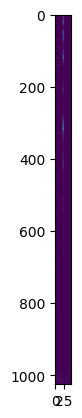

In [ ]:
print(test_outputs[0])
# spectro_0 = torch.abs(torch.nn.functional.normalize(test_outputs[0], dim=0))
spectro_0 = torch.abs(test_outputs[0])
print(spectro_0)
# spectro_0 = torch.pow(10, normalized)

spectro_0 = torch.pow(10, spectro_0)
spectro_0 = spectro_0.reshape((1025, 44))
plt.imshow(np.array(spectro_0.cpu()))

In [ ]:
import librosa
import soundfile as sf
audio_signal = librosa.core.spectrum.griffinlim(np.array(spectro_0.cpu()))
sf.write(f'{data_dir}/test_signal.wav', audio_signal, 22050, 'PCM_24')

In [ ]:
print(librosa.core.spectrum.griffinlim)

<function griffinlim at 0x7fcb4d16e4d0>


tensor([5.0108e-02, 3.5783e-02, 1.9905e-02,  ..., 3.7097e-08, 2.6771e-04,
        5.9515e-04], device='cuda:0')


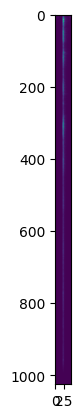

In [ ]:
print(test_labels[0])
spectro_0 = test_labels[0]
spectro_0 = spectro_0.reshape((1025, 44))
plt.imshow(np.array(spectro_0.cpu()))

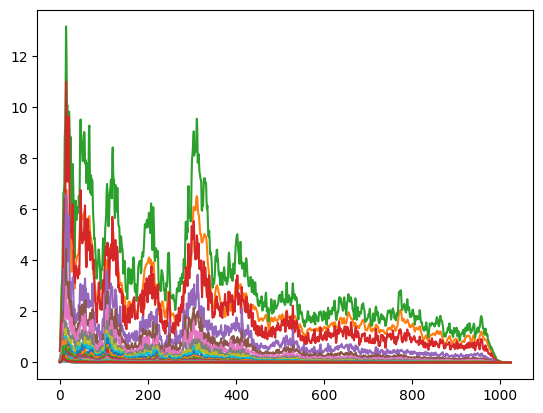

In [ ]:
plt.plot(np.array(spectro_0.cpu()))
plt.savefig(f'{data_dir}/test_figure.png')

In [ ]:
# save all of the test outputs and their expected output
for i in range(len(test_labels)):
  label_i = test_labels[i]
  label_i = label_i.reshape((1025, 44))

  output_i = torch.abs(test_outputs[i])
  output_i = torch.pow(10, output_i)
  output_i = output_i.reshape((1025, 44))

  predicted_audio_signal = librosa.core.spectrum.griffinlim(np.array(output_i.cpu()))
  sf.write(f'{data_dir}/spectro_method_outputs/{i}_predicted.wav', predicted_audio_signal, 22050, 'PCM_24')

  actual_audio_signal = librosa.core.spectrum.griffinlim(np.array(label_i.cpu()))
  sf.write(f'{data_dir}/spectro_method_outputs/{i}_actual.wav', actual_audio_signal, 22050, 'PCM_24')

  print("completed:", i)

completed: 0
